In [1]:
import torch
from torchvision import models
import torch.nn as nn

In [2]:
def set_parameter_requires_grad(model, freezing_layer_name=None, feature_extracting=False):
    """
    Fine-Tuning(False) or Feature Extracing(True)
    Flag for feature extracting
    When False, we finetune the whole model
    When True, we only update the reshaped layer params
    """
    if feature_extracting:
        for param in model.parameters():
            param.requires_grad = False # Freeze parameters
    else:
        if freezing_layer_name:
            cond = False
            for name, param in model.named_parameters():
                if freezing_layer_name == name:
                    cond = True # Freeze 
                param.requires_grad = cond
        else:
            for param in model.parameters():
                param.requires_grad = True # Trainable

In [3]:
def initialize_model(model_name, num_classes, layer_name=None, feature_extract=False, use_pretrained=True):
    # Initialize these variables which will be set in this if statement. Each of these
    #   variables is model specific.
    model_ft = None
    input_size = 0

    if model_name == "resnet50":
        """ Resnet50
        input shape (224,224,3)
        """
        model_ft = models.resnet50(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, freezing_layer_name=layer_name, feature_extracting=feature_extract)
        num_ftrs = model_ft.fc.in_features
#         model_ft.fc = nn.Linear(num_ftrs, num_classes)
        model_ft.fc = nn.Sequential(nn.Linear(num_ftrs, 512),
                                    nn.BatchNorm1d(512),
                                    nn.ReLU(),
                                    nn.Linear(512, num_classes),
                                   )
    
    elif model_name == "resnet101":
        """ Resnet101
        input shape (224,224,3)
        """
        model_ft = models.resnet101(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, freezing_layer_name=layer_name, feature_extracting=feature_extract)
        num_ftrs = model_ft.fc.in_features
#         model_ft.fc = nn.Linear(num_ftrs, num_classes)
        model_ft.fc = nn.Sequential(nn.Linear(num_ftrs, 1024),
                                    nn.BatchNorm1d(1024),
                                    nn.ReLU(),
                                    nn.Linear(1024, 512),
                                    nn.BatchNorm1d(512),
                                    nn.ReLU(),
                                    nn.Linear(512, num_classes),
                                   )
    
    elif model_name == "vgg11_bn":
        """ VGG11_bn
        """
        model_ft = models.vgg11_bn(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, freezing_layer_name=layer_name, feature_extracting=feature_extract)
        num_ftrs = model_ft.classifier[6].in_features
        model_ft.classifier[6] = nn.Linear(num_ftrs,num_classes)
    
    elif model_name == "vgg16":
        """ VGG16
        """
        model_ft = models.vgg16(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, freezing_layer_name=layer_name, feature_extracting=feature_extract)
        num_ftrs = model_ft.classifier[6].in_features
        features = list(model_ft.classifier.children())[:-1] # Remove Last Layer
        features.extend([nn.Linear(num_ftrs,num_classes)])
        model_ft.classifier = nn.Sequential(*features) # Replace the model classifier
        # model_ft.classifier[6] = nn.Linear(num_ftrs,num_classes)
        
    elif model_name == "efficientnet_b1":
        """ Efficientnet_b1
        """
        model_ft = models.efficientnet_b1(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, freezing_layer_name=layer_name, feature_extracting=feature_extract)
        num_ftrs = model_ft.classifier[1].in_features
        model_ft.classifier = nn.Linear(num_ftrs, num_classes)
    
    elif model_name == "densenet121":
        """ Densenet121
        """
        model_ft = models.densenet121(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, freezing_layer_name=layer_name, feature_extracting=feature_extract)
        num_ftrs = model_ft.classifier.in_features
        model_ft.classifier = nn.Linear(num_ftrs, num_classes)
    
    elif model_name == "densenet161":
        """ Densenet161
        """
        model_ft = models.densenet161(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, freezing_layer_name=layer_name, feature_extracting=feature_extract)
        num_ftrs = model_ft.classifier.in_features
        model_ft.classifier = nn.Linear(num_ftrs, num_classes)
        
    elif model_name == "googlenet":
        """ Googlenet
        """
        model_ft = models.googlenet(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, freezing_layer_name=layer_name, feature_extracting=feature_extract)
        num_ftrs = model_ft.fc.in_features
        model_ft.fc = nn.Linear(num_ftrs, num_classes)
        
    elif model_name == 'vit_base_patch32_384':
        model_ft = timm.create_model(model_name=model_name, pretrained=use_pretrained,img_size=(1024,1024),in_chans=3,num_classes = num_classes)
    
    elif model_name == 'vit_large_patch32_384':
        model_ft = timm.create_model(model_name=model_name, pretrained=use_pretrained,img_size=(1024,1024),in_chans=3,num_classes = num_classes)

    else:
        print("Invalid model name, exiting...")
        exit()

    return model_ft

In [4]:
class UNet_Custom(nn.Module):
    def __init__(self, num_classes=1, weight_path=None, num_features=[128, 256, 512, 1024]):
        super(UNet_Custom, self).__init__()
        model = initialize_model(model_name, num_classes, layer_name=layer_name, feature_extract=feature_extract, use_pretrained=use_pretrained)
        child_list = list(model.children()) # list(model.module.children())
        self.conv1 = child_list[0] # nn.Sequential(*list(model.module.children())[:1])
        self.bn1 = child_list[1]
        self.relu = child_list[2]
        self.maxpool = child_list[3]
        self.layer1 = child_list[4]
        self.layer2 = child_list[5]
        self.layer3 = child_list[6]
        self.layer4 = child_list[7]
        
        self.up4 = self.__upsample__(in_feature=num_features[3]*2, out_feature=num_features[2])
        self.up3 = self.__upsample__(in_feature=num_features[2]*3, out_feature=num_features[1])
        self.up2 = self.__upsample__(in_feature=num_features[1]*3, out_feature=num_features[0])
        self.up1 = self.__upsample__(in_feature=num_features[0]*3, out_feature=64)
        
        self.final_conv = nn.ConvTranspose2d(in_channels=64, out_channels=num_classes, kernel_size=2, stride=2)
        
        for m in self.modules(): # Using Kaiming initializer, initialize the weight of upsampling
            if isinstance(m, nn.ConvTranspose2d):
                torch.nn.init.kaiming_uniform_(m.weight.data)
                
    def __upsample__(self, in_feature, out_feature):
        layers = []
        
        mid_feature = int(in_feature/2)
        for layer in range(2): 
            layers += [nn.Conv2d(in_channels=in_feature, out_channels=mid_feature, kernel_size=3, stride=1, padding=1), 
                       nn.BatchNorm2d(num_features=mid_feature), 
                       nn.ReLU()]
            in_feature = mid_feature
        layers += [nn.ConvTranspose2d(in_channels=mid_feature, out_channels=out_feature, kernel_size=2, stride=2)]
        
        for m in self.modules(): # Using Kaiming initializer, initialize the weight of upsampling
            if isinstance(m, nn.Conv2d):
                torch.nn.init.kaiming_uniform_(m.weight.data)
            if isinstance(m, nn.ConvTranspose2d):
                torch.nn.init.kaiming_uniform_(m.weight.data)
        
        return nn.Sequential(*layers)        
    
    def forward(self, x):
        x1 = self.conv1(x)
        x1 = self.bn1(x1)
        x1 = self.relu(x1)
        x1 = self.maxpool(x1)
        
        x1 = self.layer1(x1)
        x2 = self.layer2(x1)
        x3 = self.layer3(x2)
        x4 = self.layer4(x3)
        
        u4 = self.up4(x4)
        u4 = torch.cat((u4, x3), dim=1)
        
        u3 = self.up3(u4)
        u3 = torch.cat((u3, x2), dim=1)
        
        u2 = self.up2(u3)
        u2 = torch.cat((u2, x1), dim=1)
        
        u1 = self.up1(u2)
        
        output = self.final_conv(u1)
        return output

In [5]:
model_name = 'resnet50'
layer_name = None
feature_extract = False
use_pretrained = None

In [6]:
model = UNet_Custom(num_classes=5, weight_path=None)
model

c:\Users\balin\anaconda3\envs\paper\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\balin\anaconda3\envs\paper\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


UNet_Custom(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride

In [7]:
from torchsummary import summary
summary(model, (3, 224, 224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 112, 112]           9,408
       BatchNorm2d-2         [-1, 64, 112, 112]             128
              ReLU-3         [-1, 64, 112, 112]               0
         MaxPool2d-4           [-1, 64, 56, 56]               0
            Conv2d-5           [-1, 64, 56, 56]           4,096
       BatchNorm2d-6           [-1, 64, 56, 56]             128
              ReLU-7           [-1, 64, 56, 56]               0
            Conv2d-8           [-1, 64, 56, 56]          36,864
       BatchNorm2d-9           [-1, 64, 56, 56]             128
             ReLU-10           [-1, 64, 56, 56]               0
           Conv2d-11          [-1, 256, 56, 56]          16,384
      BatchNorm2d-12          [-1, 256, 56, 56]             512
           Conv2d-13          [-1, 256, 56, 56]          16,384
      BatchNorm2d-14          [-1, 256,

In [8]:
from torchviz import make_dot
x = torch.randn(2, 3, 224, 224)
y = model(x)

In [9]:
y.shape

torch.Size([2, 5, 224, 224])

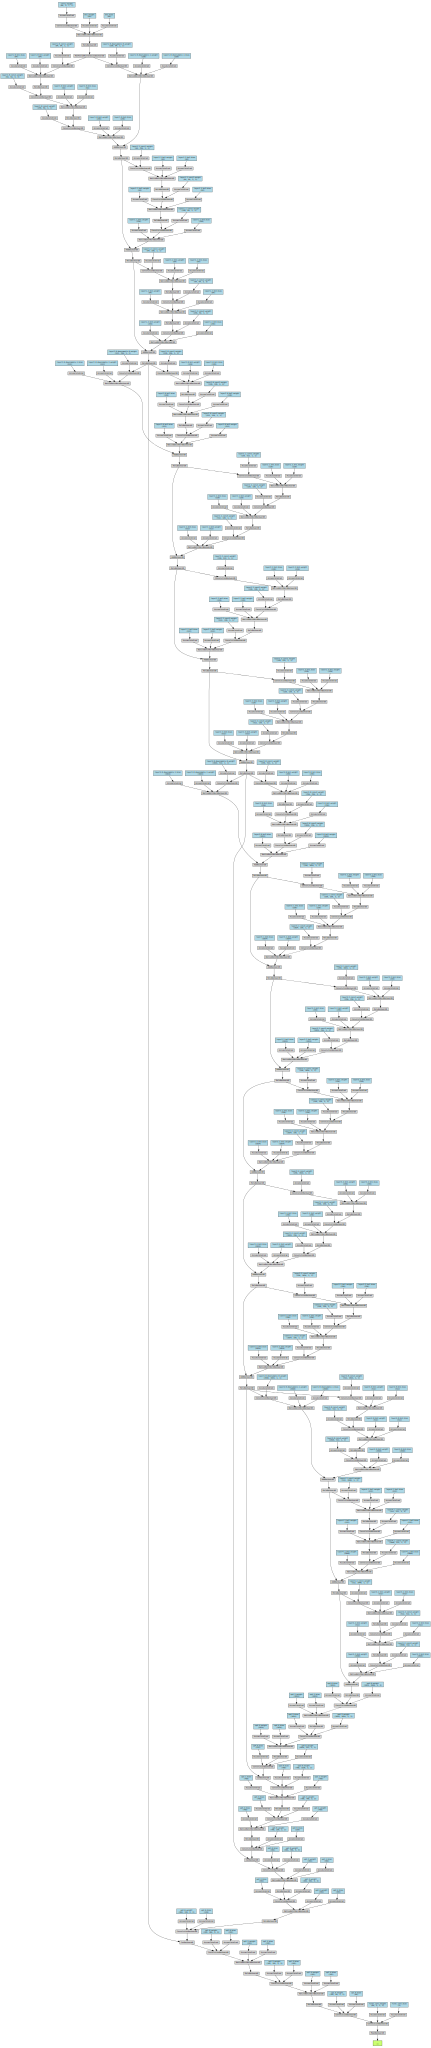

In [10]:
make_dot(y.mean(), params=dict(model.named_parameters()))